<a class="anchor" id="0.1"></a>

## Table of Contents
1. [Import labriraries and variables](#1)
2. [О датасете/EDA](#2)
3. [Feature Engineering](#3)
4. [Train models](#4)

## Import labriraries and variables
<a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [13]:
import pandas as pd
import numpy as np
import pyarrow as pa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier



In [2]:
# variables 
main_dir = "/kaggle/input/alfa-challenge/"
second_dir = "/kaggle/input/new-tr-ac/"

In [3]:
transaction = pd.read_parquet(main_dir + "df_transaction.pa", engine="pyarrow")
train = pd.read_parquet(main_dir + "train.pa", engine="pyarrow")
train_encoded = pd.read_parquet(second_dir + "train_encoded.pa", engine="pyarrow")

## О датасете/EDA
<a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

### DataSet "Transaction"
client_num - номер клиента

date_time - время транзакции

mcc_code - МСС код

merchant_name - hash имени мерчанта

amount - сумма транзакции

In [33]:
transaction

,client_num,date_time,mcc_code,merchant_name,amount
0,0,2024-07-18 16:04:00,8099,a011100358d0f73ea8f3e860ef5564e3ba9cb217b7b90c...,2900
1,0,2024-07-22 16:31:00,5411,f3855606fc7244ec2f37ea01a4b2b66933d0e965bf4aec...,455
2,0,2024-07-24 16:23:00,5541,786270fa33ad4ac2a3c0e52e888005aa7f98beadbf8986...,1003
3,0,2024-07-28 15:51:00,5691,54887ad4a8df7e260a3ac85e59128a947c50d4423f6330...,1480
4,0,2024-07-28 18:00:00,5331,21617559a372c7cca155208c87be6c84ce97b5f8775589...,88
...,...,...,...,...,...
13508150,109142,2024-08-19 21:32:00,6011,01784811094a8bd592cb35ee21e98c934839341e2b9d14...,14000
13508151,109142,2024-08-19 21:40:00,6011,01784811094a8bd592cb35ee21e98c934839341e2b9d14...,24000
13508152,109142,2024-08-19 21:46:00,6011,01784811094a8bd592cb35ee21e98c934839341e2b9d14...,23000
13508153,109142,2024-08-19 22:04:00,6011,01784811094a8bd592cb35ee21e98c934839341e2b9d14...,32000


In [34]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13508155 entries, 0 to 13508154
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   client_num     int64         
 1   date_time      datetime64[us]
 2   mcc_code       object        
 3   merchant_name  object        
 4   amount         int64         
dtypes: datetime64[us](1), int64(2), object(2)
memory usage: 515.3+ MB


In [39]:
transaction.isnull().sum() / transaction.count() * 100

client_num       0.0
date_time        0.0
mcc_code         0.0
merchant_name    0.0
amount           0.0
dtype: float64

In [72]:
transaction_copy = transaction.copy()

In [100]:
transaction_copy['month'] = transaction['date_time'].dt.to_period('M')

In [101]:
transaction_copy.drop('date_time', axis=1, inplace=True)

In [74]:
transaction_copy.groupby('month')['client_num'].count()

month
2024-07    4441222
2024-08    4577178
2024-09    4489751
2024-10          4
Freq: M, Name: client_num, dtype: int64

В основном покупки совершили в июле месяце. Можно будет проверить, есть ли клиенты из июля в августе и в сентябре.

In [75]:
transaction_copy.groupby(['month', 'client_num'])['amount'].sum()

month    client_num
2024-07  0                7261
         1              422749
         2              114647
         3             1483913
         4               91422
                        ...   
2024-09  109141            378
2024-10  13168            3280
         26937             132
         78137              64
         93720              31
Name: amount, Length: 298590, dtype: int64

In [44]:
filtered_data = transaction_copy.groupby(['month', 'client_num']).agg({
    'amount': ['sum', 'mean', 'min', 'max'],
    'mcc_code': 'count'
}).reset_index()
filtered_data

month client_num   amount                              mcc_code
                                sum          mean   min      max    count
0       2024-07          0     7261    726.100000    39     2900       10
1       2024-07          1   422749   4449.989474     6   100000       95
2       2024-07          2   114647    895.679688    23    14697      128
3       2024-07          3  1483913  35331.261905     2  1000000       42
4       2024-07          4    91422   1523.700000    24    50000       60
...         ...        ...      ...           ...   ...      ...      ...
298585  2024-09     109141      378    378.000000   378      378        1
298586  2024-10      13168     3280   3280.000000  3280     3280        1
298587  2024-10      26937      132    132.000000   132      132        1
298588  2024-10      78137       64     64.000000    64       64        1
298589  2024-10      93720       31     31.000000    31       31        1

[298590 rows x 7 columns]

In [13]:
transaction_copy.mcc_code.unique().shape[0], transaction_copy.merchant_name.unique().shape[0]

(320, 666279)

In [77]:
transaction_copy.groupby(['client_num'])['mcc_code'].count()

client_num
0         132
1         240
2         300
3         147
4         122
         ... 
109138     16
109139     15
109140     18
109141     16
109142     15
Name: mcc_code, Length: 109143, dtype: int64

Тут, скорее всего можно понять, как много человек тратит деньги в различных категориях

In [78]:
transaction_copy.groupby(['mcc_code'])['merchant_name'].count()

mcc_code
0742     6688
0763      239
0780     1209
1520      123
1711      214
        ...  
9311     7480
9390    17579
9399    10437
9402    15032
9406     7465
Name: merchant_name, Length: 320, dtype: int64

А тут можно можно понять, где больше всего продавцов в тех или иных категориях

### Dataset "Train"
client_num - номер клиента

target - группа риска

In [79]:
train

,client_num,target
0,94779,3
1,17279,0
2,5717,2
3,27471,1
4,72725,0
...,...,...
69995,107219,1
69996,108682,1
69997,93497,3
69998,14344,6


In [42]:
train.client_num.unique().shape[0]

70000

## Feature Engineering
<a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

In [94]:
transaction_copy.reset_index(drop=True)
transaction_copy.groupby('client_num')['mcc_code'].count().isnull().sum()

0

In [95]:
transaction_copy['sum_buys'] = transaction_copy.groupby('client_num')['mcc_code'].count().reindex(transaction_copy['client_num']).values

In [96]:
transaction_copy.isnull().sum()

client_num       0
date_time        0
mcc_code         0
merchant_name    0
amount           0
month            0
sum_buys         0
dtype: int64

In [102]:
transaction_copy

,client_num,mcc_code,merchant_name,amount,sum_buys,month
0,0,8099,a011100358d0f73ea8f3e860ef5564e3ba9cb217b7b90c...,2900,132,2024-07
1,0,5411,f3855606fc7244ec2f37ea01a4b2b66933d0e965bf4aec...,455,132,2024-07
2,0,5541,786270fa33ad4ac2a3c0e52e888005aa7f98beadbf8986...,1003,132,2024-07
3,0,5691,54887ad4a8df7e260a3ac85e59128a947c50d4423f6330...,1480,132,2024-07
4,0,5331,21617559a372c7cca155208c87be6c84ce97b5f8775589...,88,132,2024-07
...,...,...,...,...,...,...
13508150,109142,6011,01784811094a8bd592cb35ee21e98c934839341e2b9d14...,14000,15,2024-08
13508151,109142,6011,01784811094a8bd592cb35ee21e98c934839341e2b9d14...,24000,15,2024-08
13508152,109142,6011,01784811094a8bd592cb35ee21e98c934839341e2b9d14...,23000,15,2024-08
13508153,109142,6011,01784811094a8bd592cb35ee21e98c934839341e2b9d14...,32000,15,2024-08


In [103]:
transaction_copy['sum_amount'] = transaction_copy.groupby(['month', 'client_num'])['amount'].transform('sum')

In [104]:
transaction_copy.isnull().sum()

client_num       0
mcc_code         0
merchant_name    0
amount           0
sum_buys         0
month            0
sum_amount       0
dtype: int64

In [105]:
transaction_copy.drop(columns=['merchant_name', 'amount', 'mcc_code'], inplace=True)
transaction_copy.drop_duplicates(subset=['client_num'], inplace=True)

In [106]:
transaction_copy.isnull().sum()

client_num    0
sum_buys      0
month         0
sum_amount    0
dtype: int64

In [107]:
transaction_copy

,client_num,sum_buys,month,sum_amount
0,0,132,2024-07,7261
132,1,240,2024-07,422749
372,2,300,2024-07,114647
672,3,147,2024-07,1483913
819,4,122,2024-07,91422
...,...,...,...,...
13508075,109138,16,2024-08,131817
13508091,109139,15,2024-07,2996
13508106,109140,18,2024-07,369
13508124,109141,16,2024-07,12050


In [110]:
train_merge = train.merge(transaction_copy, on='client_num', how='left')

In [111]:
train_merge.isnull().sum()

client_num    0
target        0
sum_buys      0
month         0
sum_amount    0
dtype: int64

In [112]:
train_merge['month'] = train_merge['month'].astype(str)

In [113]:
train_merge

,client_num,target,sum_buys,month,sum_amount
0,94779,3,18,2024-07,9700
1,17279,0,41,2024-09,7787
2,5717,2,89,2024-07,3581
3,27471,1,97,2024-07,68904
4,72725,0,38,2024-07,43733
...,...,...,...,...,...
69995,107219,1,21,2024-07,10
69996,108682,1,19,2024-07,156
69997,93497,3,17,2024-07,21500
69998,14344,6,58,2024-07,2291


In [114]:
# mapping = {
#     '2024-07': 1,
#     '2024-08': 2,
#     '2024-09': 3
# }
# train_merge_mapping = train_merge.copy()
# train_merge_mapping['month'] = train_merge_mapping['month'].map(mapping)
encoder = OneHotEncoder()
encoded = encoder.fit_transform(train_merge[['month']])
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(['month']))

In [117]:
train_encoded = pd.concat([train_merge.reset_index(drop=True), encoded_df], axis=1)
train_encoded.drop('month', axis=1, inplace=True)

In [119]:
train_encoded.isnull().sum()

client_num       0
target           0
sum_buys         0
sum_amount       0
month_2024-07    0
month_2024-08    0
month_2024-09    0
dtype: int64

In [120]:
train_encoded.to_parquet('train_encoded.pa')

In [4]:
X = train_encoded.drop(columns=['target'])
y = train_encoded['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train models
<a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

### BaseLine


In [5]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [6]:
# нахождение весов классов
from collections import Counter

class_counts = Counter(y_test)
class_weights = {cls: 1 / count for cls, count in class_counts.items()}

In [129]:
class_weights

{0: 0.0003322259136212625,
 1: 0.00027878449958182325,
 5: 0.0009233610341643582,
 4: 0.0006138735420503376,
 6: 0.0008787346221441124,
 3: 0.0006418485237483953,
 2: 0.0005012531328320802}

In [7]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
weights = y_test.map(class_weights)

absolute_errors = np.abs(y_test - y_pred_proba)
weighted_absolute_errors = weights * absolute_errors

# Итоговая метрика WMAE
wmae = weighted_absolute_errors.mean()
print("WMAE:", wmae)
print("MAE:", mean_absolute_error(y_test, y_pred_proba))

WMAE: 0.001418947048311262
MAE: 2.0810392857142856


In [10]:
# Оценка модели
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    model,
    X_train, y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

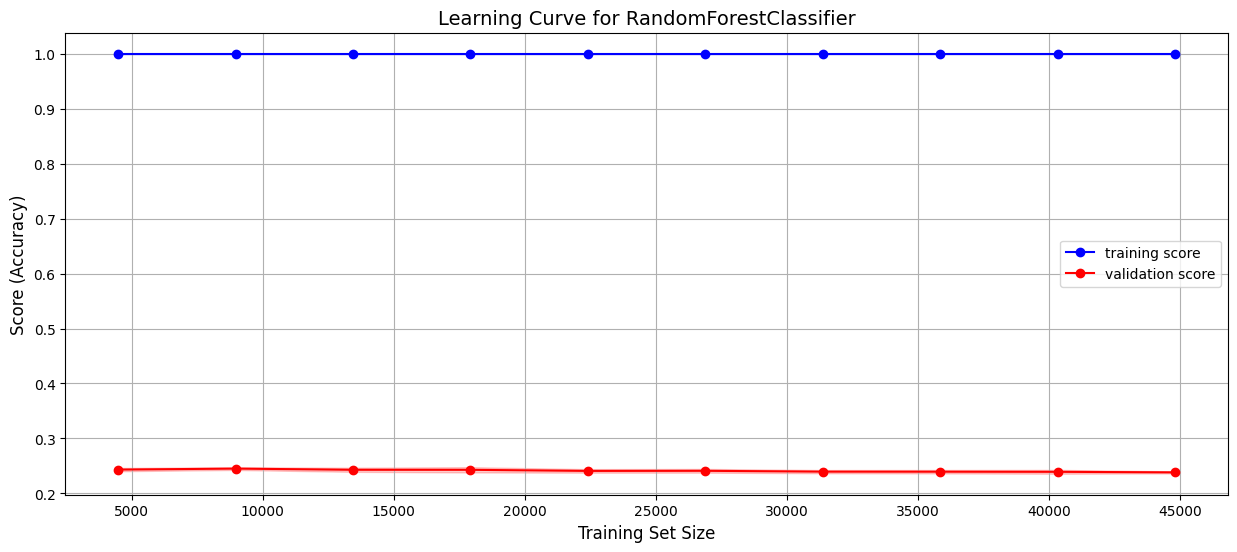

In [17]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(15, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='training score')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='validation score')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='b', alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='r', alpha=0.2)

# Настройка графика
plt.title('Learning Curve for RandomForestClassifier', fontsize=14)
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Score (Accuracy)', fontsize=12)
plt.legend()
plt.grid()
plt.show()

### Tuning parameters

In [117]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy'
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)

KeyboardInterrupt: 

In [ ]:
# метод опрных векторов svm 
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler 
ss = StandardScaler() ss.fit(X_train) 
scaled_linsvc = LinearSVC(C=0.01,random_state=42) 
scaled_linsvc.fit(ss.transform(X_train), y_train) 
y_true = y_test 
y_pred = scaled_linsvc.predict(ss.transform(X_test)) 
tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels = [0, 1]).ravel() 